## Using Qiskit Nature and VQE for finding the ground energy state of H2

Qiskit Nature is an open-source framework which supports solving quantum mechanical natural science problems using quantum computing algorithms. This includes finding ground and excited states of electronic and vibrational structure problems, measuring the dipole moments of molecular systems, solving the Ising and Fermi-Hubbard models on lattices, and much more. 

In this file we will explore finding the ground energy state of the H2 molecule using VQE.

For complete documentation on everything in the framework: [Qiskit Nature](https://doi.org/10.5281/zenodo.7828767)

<br>
 
In these examples we are using Qiskit version `1.0.2`

(
All the code blocks can be run individually in a Jupyter Notebook or in a Python script.
)

<br>

---

#### Driver

First step in finding the ground state energy is defining the molecular structure. We save this in the driver variable. We create the hydrogen molecule, which contains two H atoms. We define these in the `atom` parameter where the three digits are the location of the atom in 3D space. 

The `basis` parameter in the provided code snippet specifies the basis set used in the quantum chemical calculation. In this context, the basis set, designated as `"sto3g"`, represents Slater-Type Orbitals (STOs) with three Gaussian primitives (3G). Basis sets are sets of mathematical functions used to describe the molecular orbitals of a molecule, forming the foundation for calculating its electronic structure. The choice of basis set impacts the accuracy and computational cost of the calculation, with simpler basis sets like `"sto3g"` offering quicker but potentially less accurate results compared to more complex alternatives. What you choose for basis could have significant effect on accuracy and efficiency.

<br>

#### Mapper

For these examples we will be using the Jordan Wigner Mapper as it is the most straight-forward mapping with the simplest physical interpretation, because it maps the occupation of one spin-orbital to the occupation of one qubit. For more information on different ways of qubit mapping check the [Qiskit QubitMapper](https://qiskit-community.github.io/qiskit-nature/tutorials/06_qubit_mappers.html).

<br>

#### Ansatz

An `Ansatz` is essentially a preliminary wavefunction or state, often parameterized, used as an initial approximation in quantum computations. It serves as an informed guess for solving specific problems, like identifying the ground state of a quantum system.

In this example we use the base Unitary Coupled Cluster ([UCC](https://qiskit-community.github.io/qiskit-nature/stubs/qiskit_nature.second_q.circuit.library.UCC.html#qiskit_nature.second_q.circuit.library.UCC)) ansatz with the Hartree-Fock initial state. The UCC ansatz is a popular choice for variational quantum algorithms, as it can be used to approximate the ground state of a quantum system by applying a series of unitary operators to a reference state. The Hartree-Fock initial state is a common choice for the reference state, as it provides a good starting point for the optimization process for molecules carrying no spin electrons. We use the [UCCSD](https://qiskit-community.github.io/qiskit-nature/stubs/qiskit_nature.second_q.circuit.library.UCCSD.html#qiskit_nature.second_q.circuit.library.UCCSD) ansatz which is a subclass of the UCC ansatz, and is specifically designed for single and double excitations.

Key step in using this ansatz is choosing the initial point. Since we picked the HartreeFock initial state before, in order to ensure we start from that, we need to initialize our initial_point with all-zero parameters. If you do not specify a starting point, it will choose a random starting point. This will greatly affect efficiency of the algorithm.

<br>

#### VQE Solver

Putting everything together, wrapping the mapper and quantum algorithm in the `GroundStateEigensolver`. This will take care of the entire workflow: 
1. generating the second-quantized operators stored in our problem (here referred to as `electronic_structure`) 
2. mapping (and potentially reducing) the operators in the qubit space 
3. running the quantum algorithm on the Hamiltonian qubit operator 
4. once converged, evaluating the additional observables at the determined ground state 

Here `calc` is an instance of the `GroundStateEigensolver` class. `solve` is a method of this class, it takes an `ElectronicStructureProblem` as input (`electronic_structure`) and returns the ground state of the problem, along with other related information. 

In [10]:
from qiskit_nature.units import DistanceUnit

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator


driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

electronic_structure = driver.run()
mapper = JordanWignerMapper()

ansatz = UCCSD(
    electronic_structure.num_spatial_orbitals,
    electronic_structure.num_particles,
    mapper,
    initial_state=HartreeFock(
        electronic_structure.num_spatial_orbitals,
        electronic_structure.num_particles,
        mapper,
    ),
)

vqe_solver = VQE(Estimator(), ansatz, SLSQP())
vqe_solver.initial_point = [0.0] * ansatz.num_parameters

calc = GroundStateEigensolver(mapper, vqe_solver)

res = calc.solve(electronic_structure)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030144
  - computed part:      -1.857275030144
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035695
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948767747]
    - computed part:      [0.0  0.0  1.388948767747]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000067747]  Total: 0.000000067747
                 (debye): [0.0  0.0  -0.000000172195]  Total: 0.000000172195
 


## Plotting results

Doing this calculation for a range of `np.linspace(0.5, 2.8, 50)` (50 points between 0.5 and 2.8) and plotting the results will give us the energy curve for the H2 molecule.

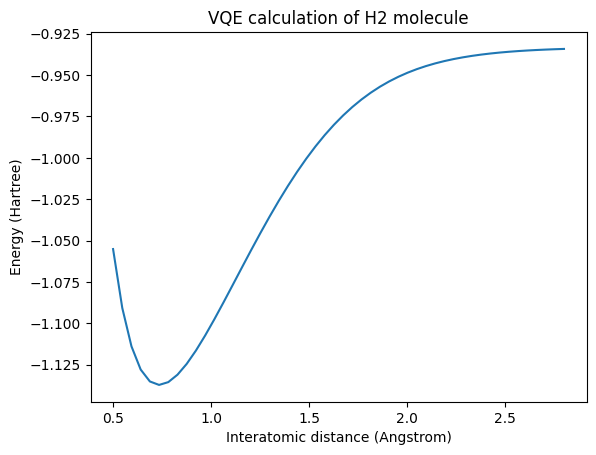

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.units import DistanceUnit

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator


distances = np.linspace(0.5, 2.8, 50)

results = []

mapper = JordanWignerMapper()


for distance in distances:
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    electronic_structure = driver.run()

    ansatz = UCCSD(
        electronic_structure.num_spatial_orbitals,
        electronic_structure.num_particles,
        mapper,
        initial_state=HartreeFock(
            electronic_structure.num_spatial_orbitals,
            electronic_structure.num_particles,
            mapper,
        ),
    )
    
    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    calc = GroundStateEigensolver(mapper, vqe_solver)
    res = calc.solve(electronic_structure)
    results.append((distance, res.total_energies[0]))

# Plot the results
plt.plot([x[0] for x in results], [x[1] for x in results])
plt.xlabel('Interatomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('VQE calculation of H2 molecule')
plt.show()

The minimum of the curve is the ground state energy at the equilibrium bond distance of the H2 molecule. We can find this by using the `min` function in Python and specifying the key as the energy.

In [12]:
min_result = min(results, key=lambda x: x[1])

print(f"The minimal ground state energy is {min_result[1]} at inter atomic distance {min_result[0]}")
print(f"{min_result[1] * 27.2114} eV")

The minimal ground state energy is -1.1373060261423558 at inter atomic distance 0.7346938775510203
-30.9476891997701 eV


## Using a classical optimizer to find the minimum ground state energy

If we put the VQE calculation in a function, we can use a classical optimizer to find the minimum of the curve. In this example we use the golden section search from scipy to find the minimum between a range of 0.5 and 1. This is a really efficient search algorithm as it only requires one new function evaluation per iteration. It is also robust and easy to use in the sense that is does not require any derivative information. However, it might not be the best choice for high-dimensional optimization problems.

In [13]:
from qiskit_nature.units import DistanceUnit

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator

from scipy.optimize import golden


def vqe_calculation(distance):
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    electronic_structure = driver.run()

    ansatz = UCCSD(
        electronic_structure.num_spatial_orbitals,
        electronic_structure.num_particles,
        mapper,
        initial_state=HartreeFock(
            electronic_structure.num_spatial_orbitals,
            electronic_structure.num_particles,
            mapper,
        ),
    )
    
    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    calc = GroundStateEigensolver(mapper, vqe_solver)
    res = calc.solve(electronic_structure)
    
    return res.total_energies[0]

mapper = JordanWignerMapper()

# Use the golden section search from scipy to find the minimum
result = golden(vqe_calculation, brack=(0.5, 1))
print(f"The minimal ground state energy is at interatomic distance {result} \nCorresponding energy {vqe_calculation(result)}")

The minimal ground state energy is at interatomic distance 0.7348645578016573 
Corresponding energy -1.1373060511647608


## Finding the real ground state energy using classical numpy method

To find the exact ground state energy of the H2 molecule we can use a purely classical solver in the Qiskit Nature framework: `NumpyMinimumEigenSolver`. This eigensolver exactly diagonalizes the Hamiltonian matrix and finds the lowest eigenvalue. Although this scales badly, it will give the exact ground state energy.

Since we are using the same driver and mapper as before, we can use the same electronic structure object. But we because we are using a classical solver, we don't need an ansatz or a quantum solver. We can just use the `GroundStateEigensolver` with the `NumpyMinimumEigenSolver` as the solver.

When we have defined the VQE calculation function we can use the golden search function just as before to find the minimum of the curve.

In [14]:
from qiskit_nature.units import DistanceUnit

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_algorithms import NumPyMinimumEigensolver

from scipy.optimize import golden


def numpy_eigensolver(distance):
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    electronic_structure = driver.run()
    
    calc = GroundStateEigensolver(mapper, numpy_solver)
    res = calc.solve(electronic_structure)
    
    return res.total_energies[0]

mapper = JordanWignerMapper()
numpy_solver = NumPyMinimumEigensolver()

# Use the golden section search from scipy to find the minimum
numpy_result = golden(numpy_eigensolver, brack=(0.5, 1))
print(f"The minimal ground state energy is at interatomic distance {numpy_result} \nCorresponding energy {numpy_eigensolver(numpy_result)}")


The minimal ground state energy is at interatomic distance 0.7348651737109518 
Corresponding energy -1.1373060512221242


Comparing the results from the VQE calculation and the exact diagonalizing we can see that the VQE calculation is very close to the exact result. This is a good indication that the VQE calculation is working as expected.

In [15]:
vqe_distance = result
vqe_energy = vqe_calculation(result)

numpy_distance = numpy_result
numpy_energy = numpy_eigensolver(numpy_result)

distance_difference = abs(vqe_distance - numpy_distance)
energy_difference = abs(vqe_energy - numpy_energy)

print(f"Difference in interatomic distance: {distance_difference}")
print(f"Difference in energy: {energy_difference}")

Difference in interatomic distance: 6.159092945656752e-07
Difference in energy: 5.736477959317199e-11


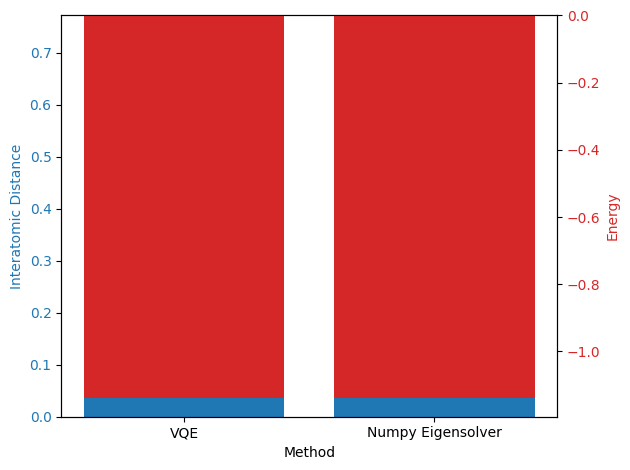

In [16]:
import matplotlib.pyplot as plt


methods = ['VQE', 'Numpy Eigensolver']
distances = [vqe_distance, numpy_distance]
energies = [vqe_energy, numpy_energy]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Method')
ax1.set_ylabel('Interatomic Distance', color=color)
ax1.bar(methods, distances, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Energy', color=color)
ax2.bar(methods, energies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()